In [56]:
import pandas as pd
import numpy as np
import math
import quandl
import datetime
import pickle

# plotting and plot stying
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
plt.style.use('seaborn')
#sns.set_style("whitegrid", {'axes.grid' : False})
#set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 80
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['text.usetex'] = False
#plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = b"\usepackage{subdepth}, \usepackage{type1cm}"


from sklearn import preprocessing, cross_validation, svm, model_selection
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# Time Series Prediction with Machine Learning

Take continous data a try to find a line for given feature vector $X$ and output vector $y$, also called label.

## Prepare data set

In [24]:
df = quandl.get('WIKI/GOOGL')

In [25]:
df.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2004-08-19,100.01,104.06,95.96,100.335,44659000.0,0.0,1.0,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,101.01,109.08,100.50,108.310,22834300.0,0.0,1.0,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,110.76,113.48,109.05,109.400,18256100.0,0.0,1.0,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,111.24,111.60,103.57,104.870,15247300.0,0.0,1.0,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,104.76,108.00,103.88,106.000,9188600.0,0.0,1.0,52.542193,54.167209,52.100830,53.164113,9188600.0


In [26]:
# building own features, hopefully with more descriptive power
df = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Low'] *100
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] *100

In [27]:
df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]

In [28]:
df.head()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume
Date,,,,
2004-08-19,50.322842,8.441017,0.324968,44659000.0
2004-08-20,54.322689,8.537313,7.227007,22834300.0
2004-08-23,54.869377,4.062357,-1.227880,18256100.0
2004-08-24,52.597363,7.753210,-5.726357,15247300.0
2004-08-25,53.164113,3.966115,1.183658,9188600.0


In [29]:
forecast_col = 'Adj. Close'
df.fillna(-99999, inplace=True)

forecast_out = int(math.ceil(0.01 * len(df)))

# shift data forward to create y
df['label'] = df[forecast_col].shift(-forecast_out)
df.dropna()
df.to_csv('./data/google.csv', sep=';')

In [30]:
df.head()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume,label
Date,,,,,
2004-08-19,50.322842,8.441017,0.324968,44659000.0,68.752232
2004-08-20,54.322689,8.537313,7.227007,22834300.0,69.639972
2004-08-23,54.869377,4.062357,-1.227880,18256100.0,69.078238
2004-08-24,52.597363,7.753210,-5.726357,15247300.0,67.839414
2004-08-25,53.164113,3.966115,1.183658,9188600.0,68.912727


In [32]:
df = pd.read_csv('./data/google.csv', sep=';', header=0, parse_dates=True, index_col=0)

X= np.array(df.drop(['label'],1))
X= preprocessing.scale(X)
X_lately = X[-forecast_out:]
X= X[:-forecast_out]

y = np.array(df['label'])
y=df['label']
y.dropna(inplace=True)
y=np.array(y)

df.dropna()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume,label
Date,,,,,
2004-08-19,50.322842,8.441017,0.324968,44659000.0,68.752232
2004-08-20,54.322689,8.537313,7.227007,22834300.0,69.639972
2004-08-23,54.869377,4.062357,-1.227880,18256100.0,69.078238
2004-08-24,52.597363,7.753210,-5.726357,15247300.0,67.839414
2004-08-25,53.164113,3.966115,1.183658,9188600.0,68.912727
2004-08-26,54.122070,3.143512,2.820391,7094800.0,70.668146
2004-08-27,53.239345,2.772258,-1.803885,6211700.0,71.219849
2004-08-30,51.162935,3.411430,-3.106003,5196700.0,72.278116
2004-08-31,51.343492,1.517228,0.048866,4917800.0,74.810934


Use train_trest_split or by hand slicing? Discussion: Does it make sense to create a random sample from the data?

In [33]:
# create random samples
# BAD
# X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

In [34]:
# slice up the actual time series
X_train = X[:3000, :]
y_train = y[:3000]

X_test = X[3000:, :]
y_test = y[3000:]


In [35]:
X_train

array([[-1.46806248,  4.29060866,  0.23168444,  4.40197951],
       [-1.45044373,  4.35649867,  4.79711512,  1.77744822],
       [-1.44803565,  1.29454505, -0.79546382,  1.22689636],
       ..., 
       [ 1.55061613, -0.89272131, -0.46262736, -0.77402966],
       [ 1.62800943,  0.2454101 ,  1.3873237 , -0.73581103],
       [ 1.62893445, -0.74452565,  0.32899484, -0.78548901]])

In [36]:
X_train = np.nan_to_num(X_train)
y_train = np.nan_to_num(y_train)
X_test = np.nan_to_num(X_test)
y_test = np.nan_to_num(y_test)

In [37]:
y_train.reshape(-1,1)

array([[  68.75223155],
       [  69.63997192],
       [  69.0782379 ],
       ..., 
       [ 789.85      ],
       [ 791.4       ],
       [ 796.87      ]])

In [38]:
X_train.reshape(-1, 4)

array([[-1.46806248,  4.29060866,  0.23168444,  4.40197951],
       [-1.45044373,  4.35649867,  4.79711512,  1.77744822],
       [-1.44803565,  1.29454505, -0.79546382,  1.22689636],
       ..., 
       [ 1.55061613, -0.89272131, -0.46262736, -0.77402966],
       [ 1.62800943,  0.2454101 ,  1.3873237 , -0.73581103],
       [ 1.62893445, -0.74452565,  0.32899484, -0.78548901]])

In [39]:
clf = LinearRegression(n_jobs=-1)

In [40]:
clf.fit(X_train, y_train.reshape(-1, 1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [41]:
accuracy = clf.score(X_test, y_test)
accuracy

0.56312562565492519

In [42]:
y_hat = clf.predict(X_test)

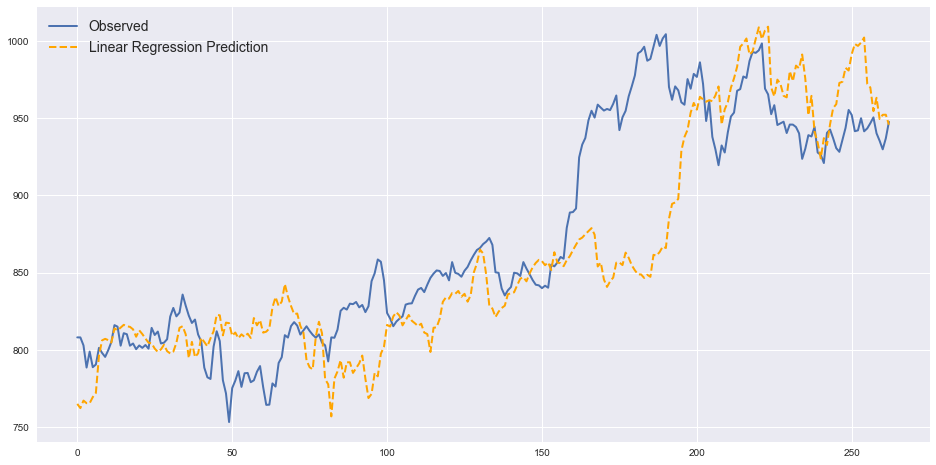

In [44]:
plt.plot(y_test, label='Observed')
plt.plot(y_hat, color='orange', linestyle='--', label='Linear Regression Prediction')
plt.legend(loc='upper left')
plt.show()

## Support Vector Regression

In [57]:
#rgr_lin = LogisticRegression().fit(X_train, y_train.reshape(-1, 1))
svr_lin = SVR(kernel='linear', C=1e3).fit(X_train, y_train.reshape(-1, 1))
svr_poly = SVR(kernel='poly', C=1e3).fit(X_train, y_train.reshape(-1, 1))
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1).fit(X_train, y_train.reshape(-1, 1))

C:\ProgramData\Anaconda3\envs\python35\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\envs\python35\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [59]:
y_hat_svr_lin = svr_lin.predict(X_test)
y_hat_svr_poly = svr_poly.predict(X_test)
y_hat_svr_rbf = svr_rbf.predict(X_test)


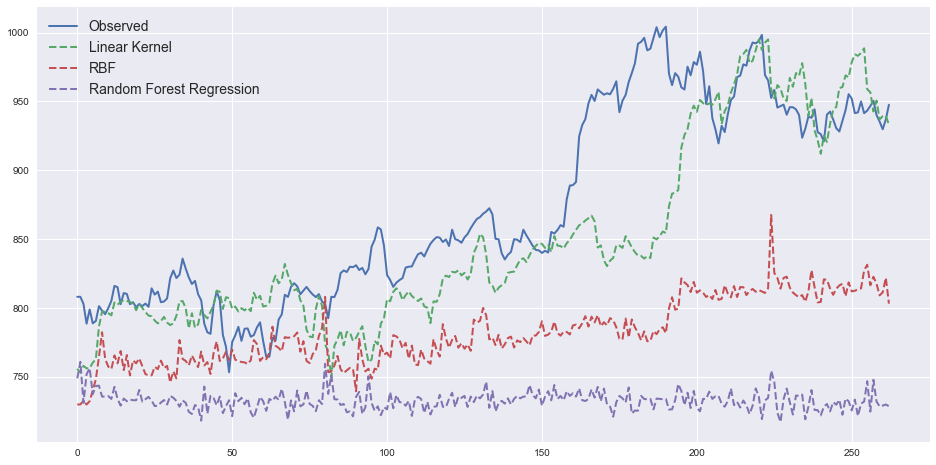

In [61]:
plt.plot(y_test, label='Observed');
plt.plot(y_hat_svr_lin, linestyle='--', label='Linear Kernel');
#plt.plot(y_hat_svr_poly, linestyle='--', label='Plynomial Kernel')
plt.plot(y_hat_svr_rbf, linestyle='--', label='RBF');
plt.plot(y_hat_regr_rf, linestyle='--', label='Random Forest Regression');
plt.legend(loc='upper left');
plt.show()

## Random Forest Regression



In [85]:
regr_rf = RandomForestRegressor(n_estimators=50,
                                max_features=3,
                                max_depth=40,
                                ).fit(X_train, y_train.reshape(-1, 1).ravel())

In [86]:
y_hat_regr_rf = regr_rf.predict(X_test)

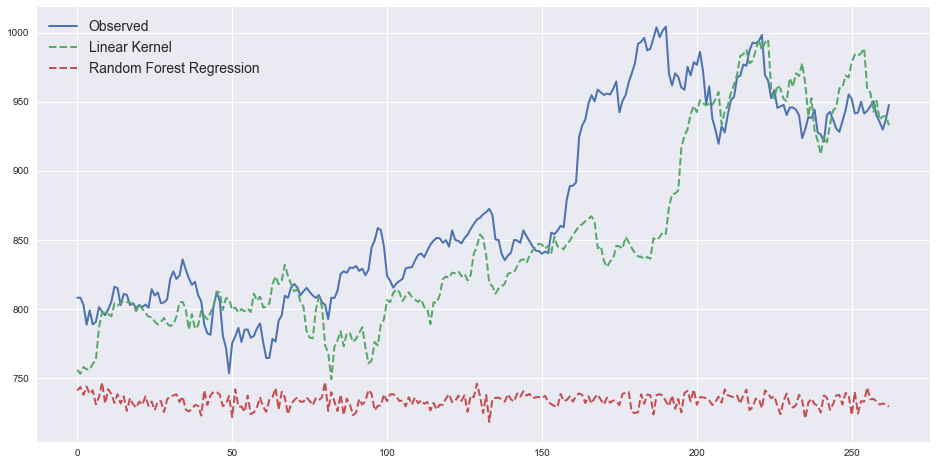

In [87]:
plt.plot(y_test, label='Observed');
plt.plot(y_hat_svr_lin, linestyle='--', label='Linear Kernel');
plt.plot(y_hat_regr_rf, linestyle='--', label='Random Forest Regression');
plt.legend(loc='upper left');
plt.show()

## Out of sample forecast

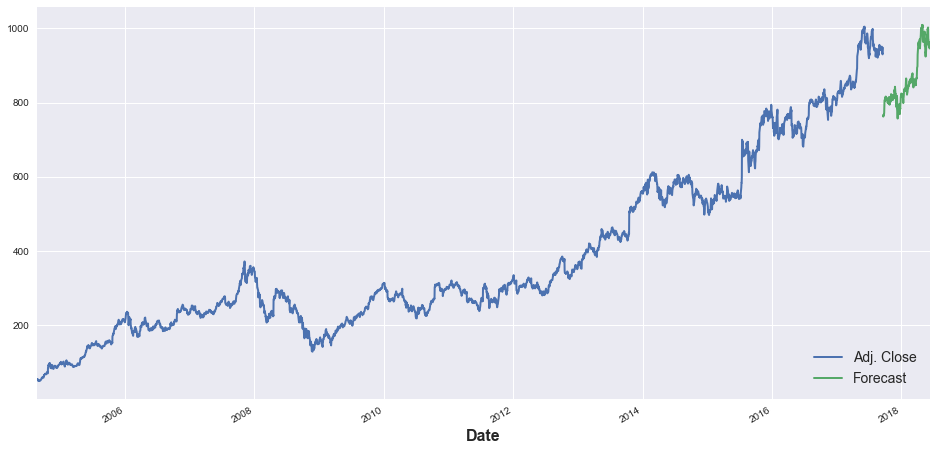

In [22]:
df['Forecast'] = np.nan

last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns) - 1)] + [i]
    
df['Adj. Close'].plot()
df['Forecast'].astype(float).plot()
plt.legend(loc=4)
plt.show()